Notebook: Estudo da variação de mfft para sinais sem ruído

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal.windows import hann
from matplotlib import gridspec
import json

In [2]:
import utils
import functions_for_param_study as funcstud

Aquisição dos sinais simulados e geração dos espectrogramas:

In [3]:
qntty = 1
test_not_save = True

In [4]:
#Import data obtained on EditedMRS_Reconstruction_Challenge github -- Ground-truths
with h5py.File('../sample_data.h5') as hf:
  print(hf.keys())
  gt_fids = hf["ground_truth_fids"][()][:qntty]
  ppm = hf["ppm"][()][:qntty]
  t = hf["t"][()][:qntty]
  print(gt_fids.shape)
  print(ppm.shape)
  print(t.shape)

<KeysViewHDF5 ['ground_truth_fids', 'ppm', 't']>
(100, 2048, 2)
(100, 2048)
(100, 2048)


In [5]:
dwelltime = t[0,1]-t[0,0]
bandwidth = 1/dwelltime
N = gt_fids.shape[1]

#gts
spectra_gt_fids = np.fft.fftshift(np.fft.ifft(gt_fids,n=N,axis = 1), axes = 1)
spectra_gt_diff = spectra_gt_fids[:,:,1] - spectra_gt_fids[:,:,0]
freq = np.flip(np.fft.fftshift(np.fft.fftfreq(N, d = dwelltime)))

#to get ppm axis
idx_min = np.real(spectra_gt_diff[0,:]).argmin()
idx_max = np.real(spectra_gt_diff[0,:]).argmax()
#p = a*f + b
a = (ppm[0,idx_max] - ppm[0,idx_min])/(freq[idx_max]-freq[idx_min])
b = ppm[0,idx_max] - a*freq[idx_max]
#ppm_aux = b + freq*a

In [6]:
mfft_ = np.arange(32,1024,20)
window_ = []
for i in range(mfft_.shape[0]):
    window_.append(hann(int(mfft_[i]),sym=True))
hop_ = 8
norm_ = 'abs'
spgram_mfft = {}
for i in range(mfft_.shape[0]):
    spgram_gt, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=gt_fids[:,:,1]-gt_fids[:,:,0],bandwidth=bandwidth,window=window_[i],mfft=int(mfft_[i]),hop=hop_,norm=norm_,correct_time=True,a=a,b=b)
    spgram_mfft['mfft_'+str(mfft_[i])] = [spgram_gt, freq_spect, ppm_spect, t_spect]

Algumas colunas e linhas de interesse na análise dos espectrogramas:

In [7]:
list_of_t_spects = []
list_of_ppm_spects = []
for i in range(mfft_.shape[0]):
    list_of_t_spects.append(spgram_mfft['mfft_'+str(mfft_[i])][-1])
    list_of_ppm_spects.append(spgram_mfft['mfft_'+str(mfft_[i])][2])
idx_time_0d05 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.05)
idx_time_0d4 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.4)
idx_time_0d6 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.6)
idx_freq_0ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=0)
idx_freq_1ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=1)
idx_freq_4ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=4)
idx_freq_8ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=8)
idx_freq_8d5ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=8.5)
idx_freq_NAA = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=2.02)
idx_freq_GABA = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=3.00)
idx_freq_Glx = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=3.75)

Projeção no eixo da frequência:

(-0.1, 5.0)

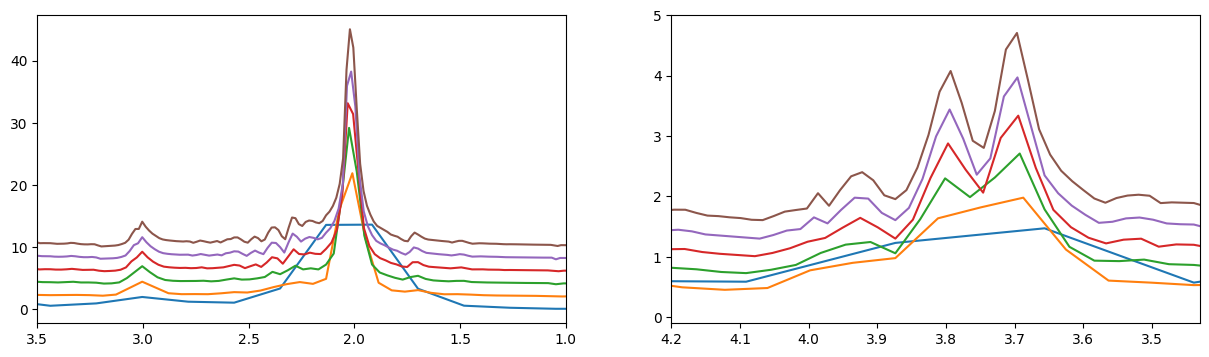

In [8]:
plot_id = np.arange(2,len(mfft_),9)
plot_abs = True
fig,ax = plt.subplots(1,2,figsize=(15,4))
for i in range(6):
    if plot_abs == True:
        aux = np.sum(np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:])),axis=1)
    else:
        aux = np.sum(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:]),axis=1)
    ax[0].plot(np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][2]),aux+2*i,label='mfft = '+str(mfft_[plot_id[i]]))
    ax[1].plot(np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][2]),aux+0.25*i,label='mfft = '+str(mfft_[plot_id[i]]))

ax[0].set_xlim(3.5,1)  
ax[1].set_xlim(4.2,3.43)
ax[1].set_ylim(-0.1,5)  

Medição da FWHM das projeções para os picos de NAA, GABA e Glx:

In [8]:
list_projections_abs = []
list_projections_real = []
fwhm_mfft = {}
idx_fwhm = {}
fwhm_mfft_real = {}
idx_fwhm_real = {}
for i in range(len(mfft_)):
    list_projections_abs.append(np.sum(np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[i])][0])), axis = 2))
    list_projections_real.append(np.sum(np.real(spgram_mfft['mfft_'+str(mfft_[i])][0]), axis = 2))
    idx_fwhm['mfft_'+str(mfft_[i])] = {}
    idx_fwhm_real['mfft_'+str(mfft_[i])] = {}

fwhm_mfft['NAA'], aux_idx_NAA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs,list_peak_idx=idx_freq_NAA,list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='positive')
fwhm_mfft['GABA'], aux_idx_GABA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs,list_peak_idx=idx_freq_GABA,list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
fwhm_mfft['Glx'], aux_idx_Glx_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs,list_peak_idx=idx_freq_Glx,list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

fwhm_mfft_real['NAA'], aux_idx_NAA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real,list_peak_idx=idx_freq_NAA,list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
fwhm_mfft_real['GABA'], aux_idx_GABA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real,list_peak_idx=idx_freq_GABA,list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
fwhm_mfft_real['Glx'], aux_idx_Glx_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real,list_peak_idx=idx_freq_Glx,list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

for i in range(len(mfft_)):
    idx_fwhm['mfft_'+str(mfft_[i])]['NAA'] = aux_idx_NAA_abs[i]
    idx_fwhm['mfft_'+str(mfft_[i])]['GABA'] = aux_idx_GABA_abs[i]
    idx_fwhm['mfft_'+str(mfft_[i])]['Glx'] = aux_idx_Glx_abs[i]
    idx_fwhm_real['mfft_'+str(mfft_[i])]['NAA'] = aux_idx_NAA_real[i]
    idx_fwhm_real['mfft_'+str(mfft_[i])]['GABA'] = aux_idx_GABA_real[i]
    idx_fwhm_real['mfft_'+str(mfft_[i])]['Glx'] = aux_idx_Glx_real[i]

(0.0, 1.0, 0.0, 1.0)

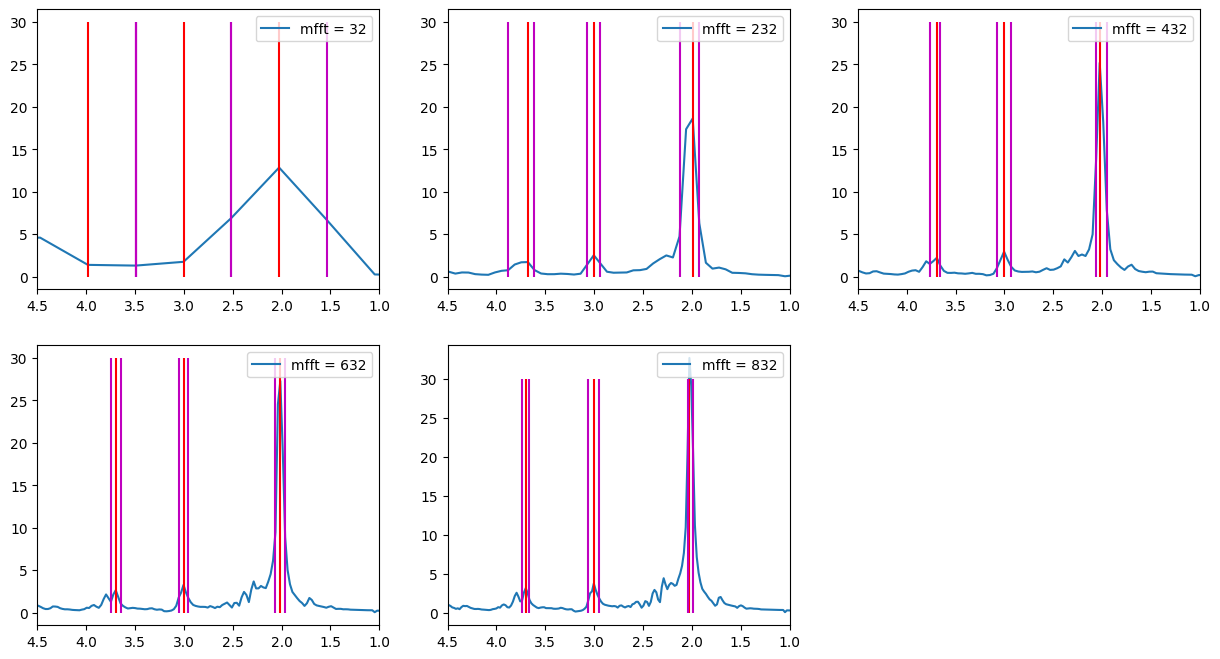

In [10]:
plot_id = np.arange(0,len(mfft_),10)
fig,ax = plt.subplots(2,3,figsize=(15,8))
for i in range(5):
    ax.flat[i].plot(np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][2]),(np.sum(np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:])),axis=1)),label='mfft = '+str(mfft_[plot_id[i]]))
    ax.flat[i].set_xlim(4.5,1)
    ax.flat[i].vlines(np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][2])[int(idx_fwhm['mfft_'+str(mfft_[plot_id[i]])]['NAA'][0,2])],0,30,color='r')
    ax.flat[i].vlines(np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][2])[int(idx_fwhm['mfft_'+str(mfft_[plot_id[i]])]['NAA'][0,0])],0,30,color='m')
    ax.flat[i].vlines(np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][2])[int(idx_fwhm['mfft_'+str(mfft_[plot_id[i]])]['NAA'][0,1])],0,30,color='m')
    ax.flat[i].vlines(np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][2])[int(idx_fwhm['mfft_'+str(mfft_[plot_id[i]])]['GABA'][0,2])],0,30,color='r')
    ax.flat[i].vlines(np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][2])[int(idx_fwhm['mfft_'+str(mfft_[plot_id[i]])]['GABA'][0,0])],0,30,color='m')
    ax.flat[i].vlines(np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][2])[int(idx_fwhm['mfft_'+str(mfft_[plot_id[i]])]['GABA'][0,1])],0,30,color='m')
    ax.flat[i].vlines(np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][2])[int(idx_fwhm['mfft_'+str(mfft_[plot_id[i]])]['Glx'][0,2])],0,30,color='r')
    ax.flat[i].vlines(np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][2])[int(idx_fwhm['mfft_'+str(mfft_[plot_id[i]])]['Glx'][0,0])],0,30,color='m')
    ax.flat[i].vlines(np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][2])[int(idx_fwhm['mfft_'+str(mfft_[plot_id[i]])]['Glx'][0,1])],0,30,color='m')
    ax.flat[i].legend(loc='upper right')
ax[1,2].axis('off')

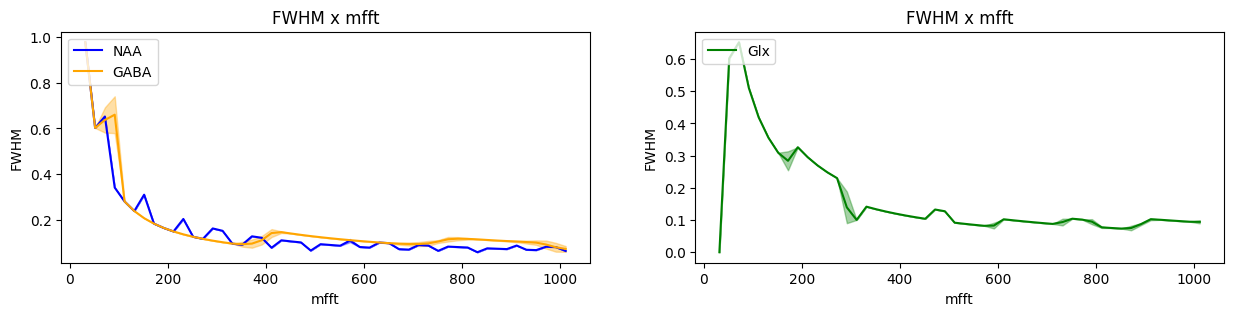

In [11]:
fig,ax = plt.subplots(1,2,figsize=(15,3))
ax[0].plot(mfft_,fwhm_mfft['NAA']['mean'],label='NAA',color='b')
ax[0].fill_between(mfft_, np.array(fwhm_mfft['NAA']['mean']) - np.array(fwhm_mfft['NAA']['std']), 
                        np.array(fwhm_mfft['NAA']['mean']) + np.array(fwhm_mfft['NAA']['std']), alpha=0.35, color = 'b')
ax[0].plot(mfft_,fwhm_mfft['GABA']['mean'],label='GABA',color='orange')
ax[0].fill_between(mfft_, np.array(fwhm_mfft['GABA']['mean']) - np.array(fwhm_mfft['GABA']['std']), 
                        np.array(fwhm_mfft['GABA']['mean']) + np.array(fwhm_mfft['GABA']['std']), alpha=0.35, color = 'orange')
ax[0].set_title('FWHM x mfft')
ax[0].set_xlabel('mfft')
ax[0].set_ylabel('FWHM')
ax[0].legend(loc='upper left')
ax[1].plot(mfft_,fwhm_mfft['Glx']['mean'],label='Glx',color='g')
ax[1].fill_between(mfft_, np.array(fwhm_mfft['Glx']['mean']) - np.array(fwhm_mfft['Glx']['std']), 
                        np.array(fwhm_mfft['Glx']['mean']) + np.array(fwhm_mfft['Glx']['std']), alpha=0.35, color = 'g')
ax[1].set_title('FWHM x mfft')
ax[1].set_xlabel('mfft')
ax[1].set_ylabel('FWHM')
ax[1].legend(loc='upper left')

(0.0, 1.0, 0.0, 1.0)

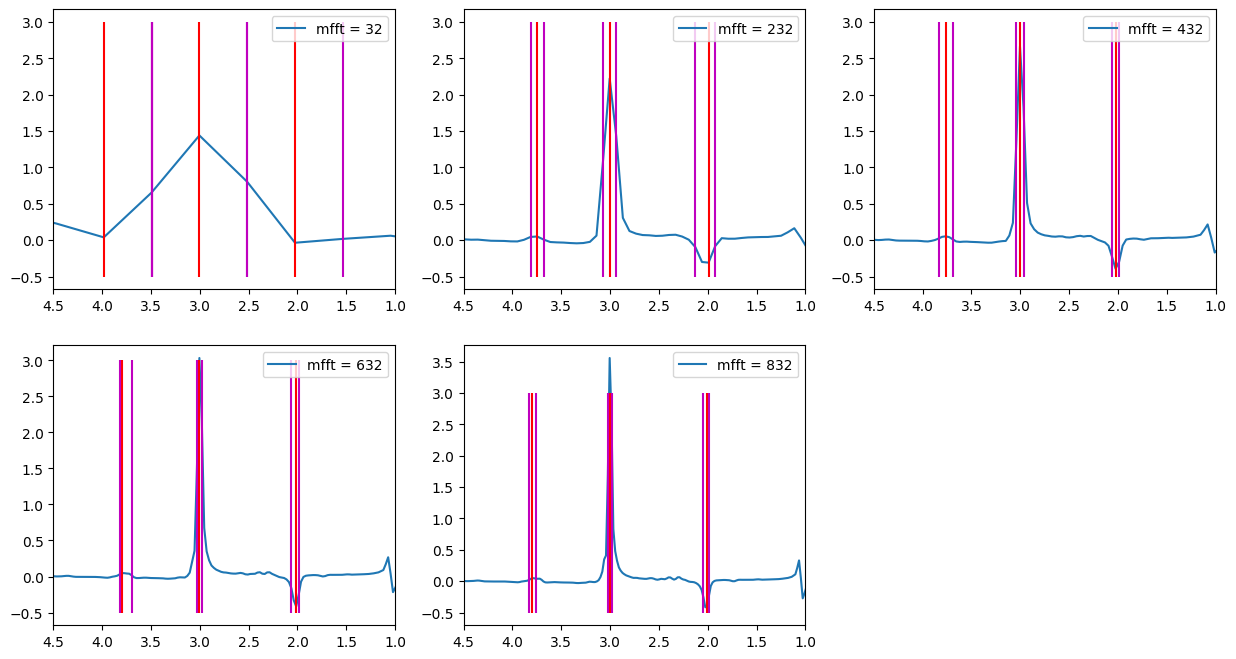

In [12]:
plot_id = np.arange(0,len(mfft_),10)
fig,ax = plt.subplots(2,3,figsize=(15,8))
for i in range(5):
    ax.flat[i].plot(np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][2]),(np.sum(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:]),axis=1)),label='mfft = '+str(mfft_[plot_id[i]]))
    ax.flat[i].set_xlim(4.5,1)
    ax.flat[i].vlines(np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][2])[int(idx_fwhm_real['mfft_'+str(mfft_[plot_id[i]])]['NAA'][0,2])],-0.5,3,color='r')
    ax.flat[i].vlines(np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][2])[int(idx_fwhm_real['mfft_'+str(mfft_[plot_id[i]])]['NAA'][0,0])],-0.5,3,color='m')
    ax.flat[i].vlines(np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][2])[int(idx_fwhm_real['mfft_'+str(mfft_[plot_id[i]])]['NAA'][0,1])],-0.5,3,color='m')
    ax.flat[i].vlines(np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][2])[int(idx_fwhm_real['mfft_'+str(mfft_[plot_id[i]])]['GABA'][0,2])],-0.5,3,color='r')
    ax.flat[i].vlines(np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][2])[int(idx_fwhm_real['mfft_'+str(mfft_[plot_id[i]])]['GABA'][0,0])],-0.5,3,color='m')
    ax.flat[i].vlines(np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][2])[int(idx_fwhm_real['mfft_'+str(mfft_[plot_id[i]])]['GABA'][0,1])],-0.5,3,color='m')
    ax.flat[i].vlines(np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][2])[int(idx_fwhm_real['mfft_'+str(mfft_[plot_id[i]])]['Glx'][0,2])],-0.5,3,color='r')
    ax.flat[i].vlines(np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][2])[int(idx_fwhm_real['mfft_'+str(mfft_[plot_id[i]])]['Glx'][0,0])],-0.5,3,color='m')
    ax.flat[i].vlines(np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][2])[int(idx_fwhm_real['mfft_'+str(mfft_[plot_id[i]])]['Glx'][0,1])],-0.5,3,color='m')
    ax.flat[i].legend(loc='upper right')
ax[1,2].axis('off')

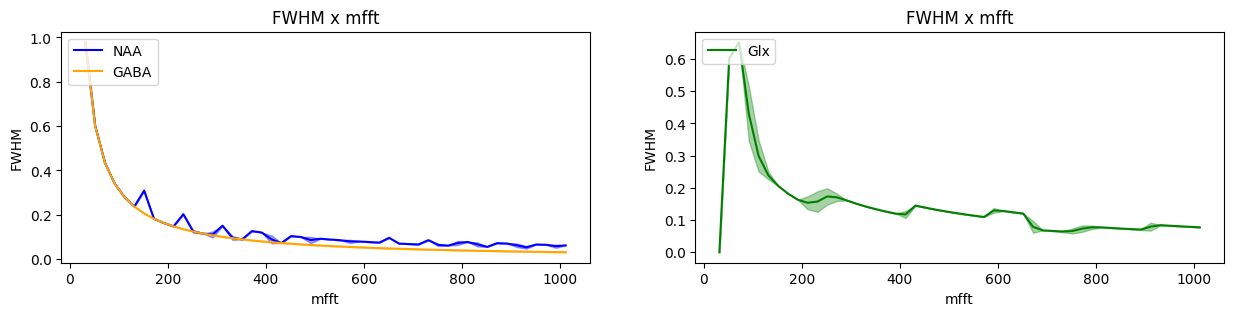

In [13]:
fig,ax = plt.subplots(1,2,figsize=(15,3))
ax[0].plot(mfft_,fwhm_mfft_real['NAA']['mean'],label='NAA',color='b')
ax[0].fill_between(mfft_, np.array(fwhm_mfft_real['NAA']['mean']) - np.array(fwhm_mfft_real['NAA']['std']), 
                        np.array(fwhm_mfft_real['NAA']['mean']) + np.array(fwhm_mfft_real['NAA']['std']), alpha=0.35, color = 'b')
ax[0].plot(mfft_,fwhm_mfft_real['GABA']['mean'],label='GABA',color='orange')
ax[0].fill_between(mfft_, np.array(fwhm_mfft_real['GABA']['mean']) - np.array(fwhm_mfft_real['GABA']['std']), 
                        np.array(fwhm_mfft_real['GABA']['mean']) + np.array(fwhm_mfft_real['GABA']['std']), alpha=0.35, color = 'orange')
ax[0].set_title('FWHM x mfft')
ax[0].set_xlabel('mfft')
ax[0].set_ylabel('FWHM')
ax[0].legend(loc='upper left')
ax[1].plot(mfft_,fwhm_mfft_real['Glx']['mean'],label='Glx',color='g')
ax[1].fill_between(mfft_, np.array(fwhm_mfft_real['Glx']['mean']) - np.array(fwhm_mfft_real['Glx']['std']), 
                        np.array(fwhm_mfft_real['Glx']['mean']) + np.array(fwhm_mfft_real['Glx']['std']), alpha=0.35, color = 'g')
ax[1].set_title('FWHM x mfft')
ax[1].set_xlabel('mfft')
ax[1].set_ylabel('FWHM')
ax[1].legend(loc='upper left')

Espectrogramas concatenados:

In [14]:
aux_concat = (np.arange(2,len(mfft_),10)).tolist()
aux_concat_NAA_idx = []
aux_concat_Glx_idx = []
plot_concat = []
for idx in aux_concat:
    plot_concat.append(mfft_[idx])
    aux_concat_NAA_idx.append(idx_freq_NAA[idx])
    aux_concat_Glx_idx.append(idx_freq_Glx[idx])
    
spgram_mfft_concat = funcstud.concatenate_different_mfft(list_mfft_idx=plot_concat,spgram_dict=spgram_mfft,time_idx=idx_time_0d4[0],fid_idx_plot=0)
spgram_mfft_concat_NAA = funcstud.concatenate_different_mfft(list_mfft_idx=plot_concat,spgram_dict=spgram_mfft,time_idx=idx_time_0d4[0],fid_idx_plot=0,centered_ppm_last=idx_freq_NAA[aux_concat[-1]],list_idx_of_centered=aux_concat_NAA_idx)
spgram_mfft_concat_Glx = funcstud.concatenate_different_mfft(list_mfft_idx=plot_concat,spgram_dict=spgram_mfft,time_idx=idx_time_0d4[0],fid_idx_plot=0,centered_ppm_last=idx_freq_Glx[aux_concat[-1]],list_idx_of_centered=aux_concat_Glx_idx)

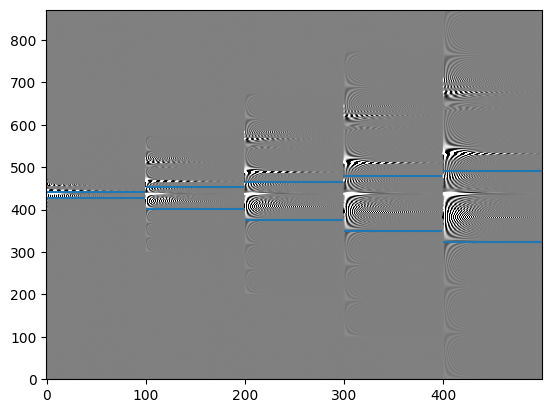

In [15]:
plt.imshow(np.real(spgram_mfft_concat), origin='lower',cmap='gray',aspect='auto',vmin=-0.04,vmax=0.04)
count = 0
center = spgram_mfft_concat.shape[0]/2
idx_aux = idx_time_0d4[0]
for i in range(2,len(mfft_),10):
    aux = spgram_mfft['mfft_'+str(mfft_[i])][0].shape[1]
    plt.hlines(center-int(aux/2)+idx_freq_1ppm[i],count,count+idx_aux-1)
    plt.hlines(center-int(aux/2)+idx_freq_4ppm[i],count,count+idx_aux-1)
    count = count+idx_aux

Espectrogramas concatenados com diferentes alinhamento para visualizar os picos de GABA, NAA e Glx:

(0.0, 1.0, 0.0, 1.0)

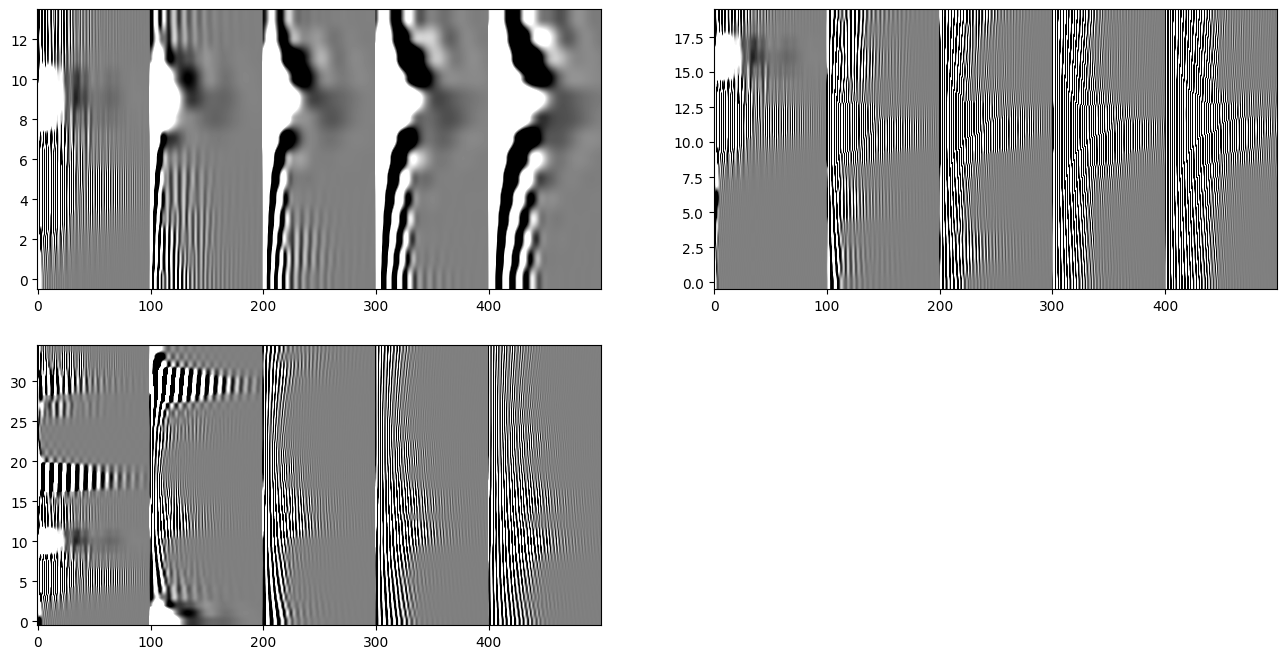

In [16]:
fig,ax = plt.subplots(2,2,figsize=(16,8))
aux = spgram_mfft['mfft_'+str(mfft_[2])][0].shape[1]
ax.flat[0].imshow(np.real(spgram_mfft_concat[int(center)-int(aux/2)+idx_freq_1ppm[2]:int(center)-int(aux/2)+idx_freq_4ppm[2],:]), origin='lower', 
             aspect='auto',cmap='gray',vmin=-0.01,vmax=0.01)
ax.flat[1].imshow(np.real(spgram_mfft_concat_NAA[370:390,:]), origin='lower', 
             aspect='auto',cmap='gray',vmin=-0.01,vmax=0.01)
ax.flat[2].imshow(np.real(spgram_mfft_concat_Glx[465:500,:]), origin='lower', 
             aspect='auto',cmap='gray',vmin=-0.01,vmax=0.01)
ax.flat[3].axis('off')

Medição do comprimento dos picos de GABA, NAA e Glx:

In [9]:
segm_dict = funcstud.segment_relevant_peaks_dict(spgram_dict=spgram_mfft,idx_list_1ppm=idx_freq_1ppm,idx_list_4ppm=idx_freq_4ppm,idx_list_GABA=idx_freq_GABA,idx_list_NAA=idx_freq_NAA,idx_list_Glx=idx_freq_Glx,idx_time_list_0d4=idx_time_0d4,idx_peaks_regions_limits_dict=idx_fwhm_real)
sum_segment = funcstud.get_length_relevant_peaks_for_different_spgrams(segm_dict=segm_dict,spgram_dict=spgram_mfft,idx_list_1ppm=idx_freq_1ppm,idx_list_4ppm=idx_freq_4ppm,idx_list_GABA=idx_freq_GABA,idx_list_NAA=idx_freq_NAA,idx_list_Glx=idx_freq_Glx)

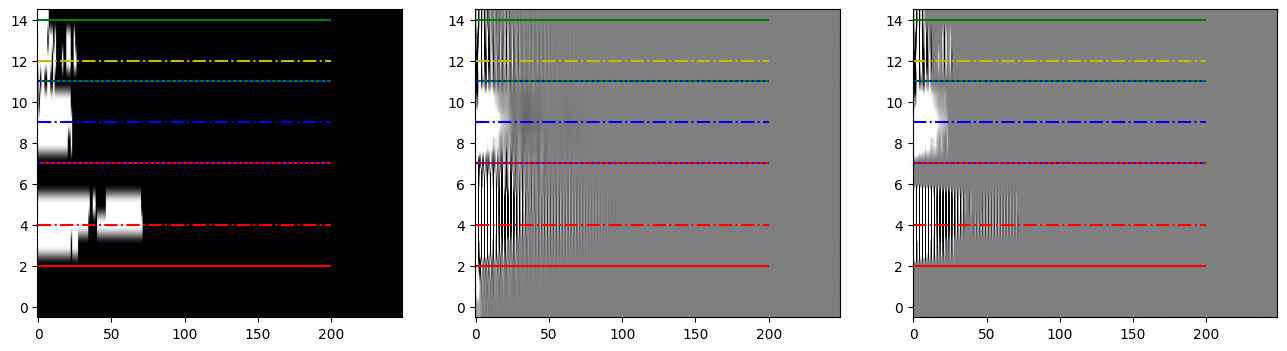

In [10]:
idx_mfft = 2
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].imshow(segm_dict['mfft_'+str(mfft_[idx_mfft])][0,:,:],cmap='gray',aspect='auto',origin='lower')
ax[1].imshow(np.real(spgram_mfft['mfft_'+str(mfft_[idx_mfft])][0][0,idx_freq_1ppm[idx_mfft]:idx_freq_4ppm[idx_mfft]+1,:]),cmap='gray',aspect='auto',origin='lower',vmin=-0.04,
            vmax=0.04)
ax[2].imshow(segm_dict['mfft_'+str(mfft_[idx_mfft])][0,:,:]*np.real(spgram_mfft['mfft_'+str(mfft_[idx_mfft])][0][0,idx_freq_1ppm[idx_mfft]:idx_freq_4ppm[idx_mfft]+1,:]),cmap='gray',aspect='auto',origin='lower',vmin=-0.04,
            vmax=0.04)
idx_NAA_plus1 = utils.give_idx_ppm_point(spgram_mfft['mfft_'+str(mfft_[idx_mfft])][2],2.50)
idx_NAA_minus1 = utils.give_idx_ppm_point(spgram_mfft['mfft_'+str(mfft_[idx_mfft])][2],1.50)
idx_GABA_plus1 = utils.give_idx_ppm_point(spgram_mfft['mfft_'+str(mfft_[idx_mfft])][2],3.50)
idx_GABA_minus1 = utils.give_idx_ppm_point(spgram_mfft['mfft_'+str(mfft_[idx_mfft])][2],2.50)
idx_Glx_plus1 = utils.give_idx_ppm_point(spgram_mfft['mfft_'+str(mfft_[idx_mfft])][2],4.00)
idx_Glx_minus1 = utils.give_idx_ppm_point(spgram_mfft['mfft_'+str(mfft_[idx_mfft])][2],3.50)
for i in range(3):
    ax[i].hlines(idx_NAA_plus1-idx_freq_1ppm[idx_mfft],0,200,color='r')
    ax[i].hlines(idx_NAA_minus1-idx_freq_1ppm[idx_mfft],0,200,color='r')
    ax[i].hlines(idx_freq_NAA[idx_mfft]-idx_freq_1ppm[idx_mfft],0,200,color='r',linestyle='dashdot')
    ax[i].hlines(idx_Glx_plus1-idx_freq_1ppm[idx_mfft],0,200,color='g')
    ax[i].hlines(idx_Glx_minus1-idx_freq_1ppm[idx_mfft],0,200,color='g')
    ax[i].hlines(idx_freq_Glx[idx_mfft]-idx_freq_1ppm[idx_mfft],0,200,color='y',linestyle='dashdot')
    ax[i].hlines(idx_GABA_plus1-idx_freq_1ppm[idx_mfft],0,200,color='b',linestyle='dotted')
    ax[i].hlines(idx_GABA_minus1-idx_freq_1ppm[idx_mfft],0,200,color='b',linestyle='dotted')
    ax[i].hlines(idx_freq_GABA[idx_mfft]-idx_freq_1ppm[idx_mfft],0,200,color='b',linestyle='dashdot')

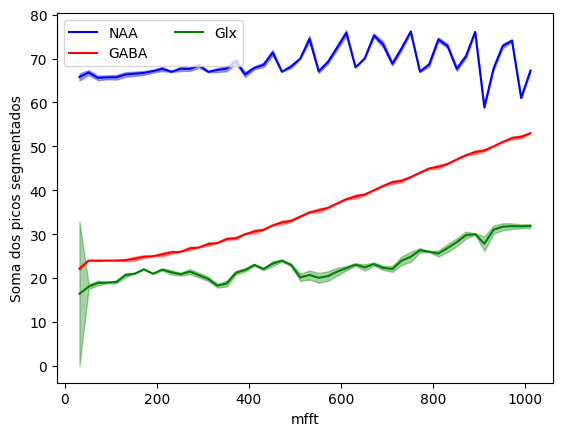

In [11]:
plt.plot(mfft_,sum_segment['NAA']['mean'],label='NAA',color='b')
plt.fill_between(mfft_, np.array(sum_segment['NAA']['mean']) - np.array(sum_segment['NAA']['std']), 
                        np.array(sum_segment['NAA']['mean']) + np.array(sum_segment['NAA']['std']), alpha=0.35, color = 'b')
plt.plot(mfft_,sum_segment['GABA']['mean'],label='GABA',color='r')
plt.fill_between(mfft_, np.array(sum_segment['GABA']['mean']) - np.array(sum_segment['GABA']['std']), 
                        np.array(sum_segment['GABA']['mean']) + np.array(sum_segment['GABA']['std']), alpha=0.35, color = 'r')
plt.plot(mfft_,sum_segment['Glx']['mean'],label='Glx',color='g')
plt.fill_between(mfft_, np.array(sum_segment['Glx']['mean']) - np.array(sum_segment['Glx']['std']), 
                        np.array(sum_segment['Glx']['mean']) + np.array(sum_segment['Glx']['std']), alpha=0.35, color = 'g')
plt.xlabel('mfft')
plt.ylabel('Soma dos picos segmentados')
plt.legend(loc='upper left',ncols=2)

O padrão de listras das imagens muda com mfft?

In [20]:
zcr_ = funcstud.get_zcr_for_relevant_peaks_for_different_spgrams(spgram_dict=spgram_mfft,idx_list_GABA=idx_freq_GABA,idx_list_NAA=idx_freq_NAA,idx_list_Glx=idx_freq_Glx,idx_time_list_0d4=idx_time_0d4)

In [21]:
aux_concat = (np.arange(19,26)).tolist()
plot_concat = []
for idx in aux_concat:
    plot_concat.append(mfft_[idx])    
spgram_mfft_concat_for_zcr = funcstud.concatenate_different_mfft(list_mfft_idx=plot_concat,spgram_dict=spgram_mfft,time_idx=idx_time_0d4[0],fid_idx_plot=0)

Text(0.5, 1.0, 'Concatenação de Re(STFT(gt)) para mffts Consecutivos')

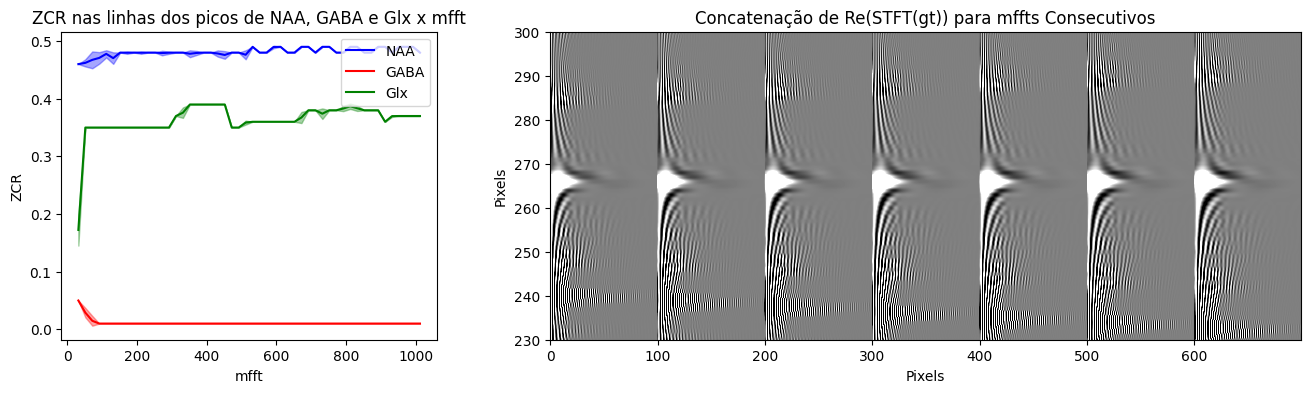

In [22]:
from matplotlib.gridspec import GridSpec
# Create figure and GridSpec
fig = plt.figure(figsize=(16, 4))
gs = GridSpec(1, 2, width_ratios=[1, 2])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(mfft_,zcr_['NAA']['mean'],color='b',label='NAA')
#ax1.plot(mfft_,np.convolve(zcr_['NAA'],(1/6)*np.ones(6),'same'),color='b',linestyle='dotted')
ax1.fill_between(mfft_, np.array(zcr_['NAA']['mean']) - np.array(zcr_['NAA']['std']), 
                        np.array(zcr_['NAA']['mean']) + np.array(zcr_['NAA']['std']), alpha=0.35, color = 'b')
ax1.plot(mfft_,zcr_['GABA']['mean'],color='r',label='GABA')
ax1.fill_between(mfft_, np.array(zcr_['GABA']['mean']) - np.array(zcr_['GABA']['std']), 
                        np.array(zcr_['GABA']['mean']) + np.array(zcr_['GABA']['std']), alpha=0.35, color = 'r')
ax1.plot(mfft_,zcr_['Glx']['mean'],color='g',label='Glx')
#ax1.plot(mfft_,np.convolve(zcr_['Glx'],(1/6)*np.ones(6),'same'),color='g',linestyle='dotted')
ax1.fill_between(mfft_, np.array(zcr_['Glx']['mean']) - np.array(zcr_['Glx']['std']), 
                        np.array(zcr_['Glx']['mean']) + np.array(zcr_['Glx']['std']), alpha=0.35, color = 'g')
ax1.legend(loc='upper right')
ax1.set_title('ZCR nas linhas dos picos de NAA, GABA e Glx x mfft')
ax1.set_ylabel('ZCR')
ax1.set_xlabel('mfft')

ax2.imshow(np.real(spgram_mfft_concat_for_zcr),vmax = 0.04,vmin = -0.04,aspect='auto',cmap='gray',origin='lower')
#ax2.set_xlim(int(19*idx_aux_all),int(26*idx_aux_all))
ax2.set_ylim(230,300)
ax2.set_xlabel('Pixels')
ax2.set_ylabel('Pixels')
ax2.set_title('Concatenação de Re(STFT(gt)) para mffts Consecutivos')

Get some statistical insights:

First, let's divide the image in sections of ppm:

In [23]:
sections = [-4,-3,-2,-1,0,1,1.50,2.50,3.50,4,5,6,7,8.50,9,10]
idx_time_list_sup = []
for i in range(len(mfft_)):
    idx_time_list_sup.append([idx_time_0d05[i],idx_time_0d05[i],idx_time_0d05[i],idx_time_0d05[i],idx_time_0d05[i],
                            idx_time_0d4[i],idx_time_0d4[i],idx_time_0d4[i],idx_time_0d4[i],idx_time_0d4[i],
                            idx_time_0d05[i],idx_time_0d05[i],
                            idx_time_0d4[i],idx_time_0d05[i],idx_time_0d05[i]])
max_sec, mean_sec, std_sec = funcstud.get_max_mean_std_per_sections_for_different_spgrams(spgram_dict=spgram_mfft, part='real', sections=sections, idx_time_list_sup=idx_time_list_sup)

idx_time_list_inf = []
for i in range(len(mfft_)):
    idx_time_list_inf.append([idx_time_0d6[i]])
max_sec_aux, mean_sec_aux, std_sec_aux = funcstud.get_max_mean_std_per_sections_for_different_spgrams(spgram_dict=spgram_mfft, part='real', sections=[1,4], idx_time_list_inf=idx_time_list_inf)
max_sec['residual'] = max_sec_aux['1:4']
mean_sec['residual'] = mean_sec_aux['1:4']
std_sec['residual'] = std_sec_aux['1:4']

Observe how the maximum value changes in every region with mfft:

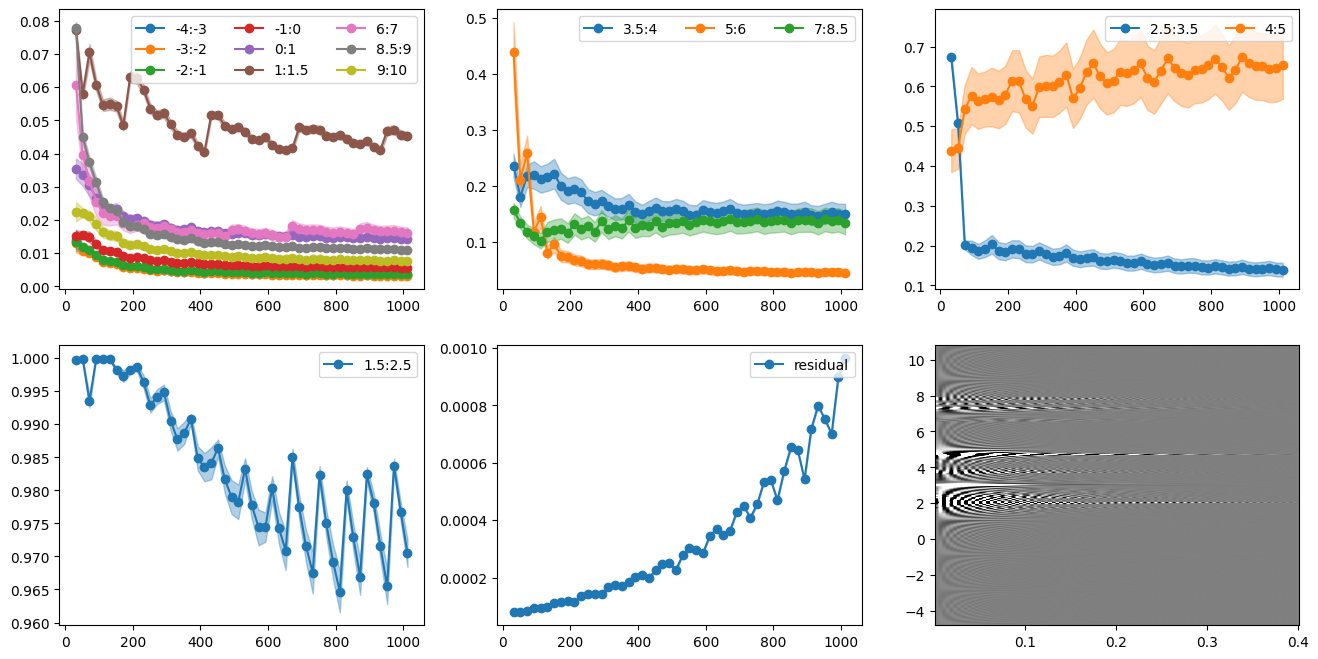

In [24]:
fig,ax = plt.subplots(2,3,figsize=(16,8))
sections = [-4,-3,-2,-1,0,1,1.50,2.50,3.50,4,5,6,7,8.50,9,10]

first_plot = [0,1,2,3,4,5,11,13,14]
second_plot = [8,10,12]
third_plot = [7,9]
fourth_plot = [6]
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

for j in range(len(first_plot)):
        aux = max_sec[str(sections[first_plot[j]])+':'+str(sections[first_plot[j]+1])]['mean']
        aux_std = max_sec[str(sections[first_plot[j]])+':'+str(sections[first_plot[j]+1])]['std']
        ax.flat[0].plot(mfft_,aux,label =str(sections[first_plot[j]])+':'+str(sections[first_plot[j]+1]),marker='o',color=colors[j])
        ax.flat[0].fill_between(mfft_, np.array(aux) - np.array(aux_std), 
                        np.array(aux) + np.array(aux_std), alpha=0.35, color=colors[j])
for j in range(len(second_plot)):
        aux = max_sec[str(sections[second_plot[j]])+':'+str(sections[second_plot[j]+1])]['mean']
        aux_std = max_sec[str(sections[second_plot[j]])+':'+str(sections[second_plot[j]+1])]['std']
        ax.flat[1].plot(mfft_,aux,label =str(sections[second_plot[j]])+':'+str(sections[second_plot[j]+1]),marker='o',color=colors[j])
        ax.flat[1].fill_between(mfft_, np.array(aux) - np.array(aux_std), 
                        np.array(aux) + np.array(aux_std), alpha=0.35, color=colors[j])
for j in range(len(third_plot)):
        aux = max_sec[str(sections[third_plot[j]])+':'+str(sections[third_plot[j]+1])]['mean']
        aux_std = max_sec[str(sections[third_plot[j]])+':'+str(sections[third_plot[j]+1])]['std']
        ax.flat[2].plot(mfft_,aux,label =str(sections[third_plot[j]])+':'+str(sections[third_plot[j]+1]),marker='o',color=colors[j])
        ax.flat[2].fill_between(mfft_, np.array(aux) - np.array(aux_std), 
                        np.array(aux) + np.array(aux_std), alpha=0.35, color=colors[j])
for j in range(len(fourth_plot)):
        aux = max_sec[str(sections[fourth_plot[j]])+':'+str(sections[fourth_plot[j]+1])]['mean']
        aux_std = max_sec[str(sections[fourth_plot[j]])+':'+str(sections[fourth_plot[j]+1])]['std']
        ax.flat[3].plot(mfft_,aux,label =str(sections[fourth_plot[j]])+':'+str(sections[fourth_plot[j]+1]),marker='o',color=colors[j])
        ax.flat[3].fill_between(mfft_, np.array(aux) - np.array(aux_std), 
                        np.array(aux) + np.array(aux_std), alpha=0.35, color=colors[j])
ax.flat[4].plot(mfft_,max_sec['residual']['mean'],label='residual',marker='o')
ax.flat[4].fill_between(mfft_, np.array(max_sec['residual']['mean']) - np.array(max_sec['residual']['std']), 
                        np.array(max_sec['residual']['mean']) + np.array(max_sec['residual']['std']), alpha=0.35, color=colors[j])
for i in range(5):
    ax.flat[i].legend(loc='upper right',ncols=3)
    
ax.flat[5].imshow(np.real(spgram_mfft['mfft_'+str(mfft_[45])][0][0,:,:idx_time_0d4[45]]), origin='lower',cmap='gray',aspect='auto',vmin=-0.04,vmax=0.04,
            extent = (spgram_mfft['mfft_'+str(mfft_[45])][-1][0],spgram_mfft['mfft_'+str(mfft_[45])][-1][idx_time_0d4[45]],
                     np.flip(spgram_mfft['mfft_'+str(mfft_[45])][2])[0],np.flip(spgram_mfft['mfft_'+str(mfft_[45])][2])[-1]))

Using these values we can segment the regions of the image:

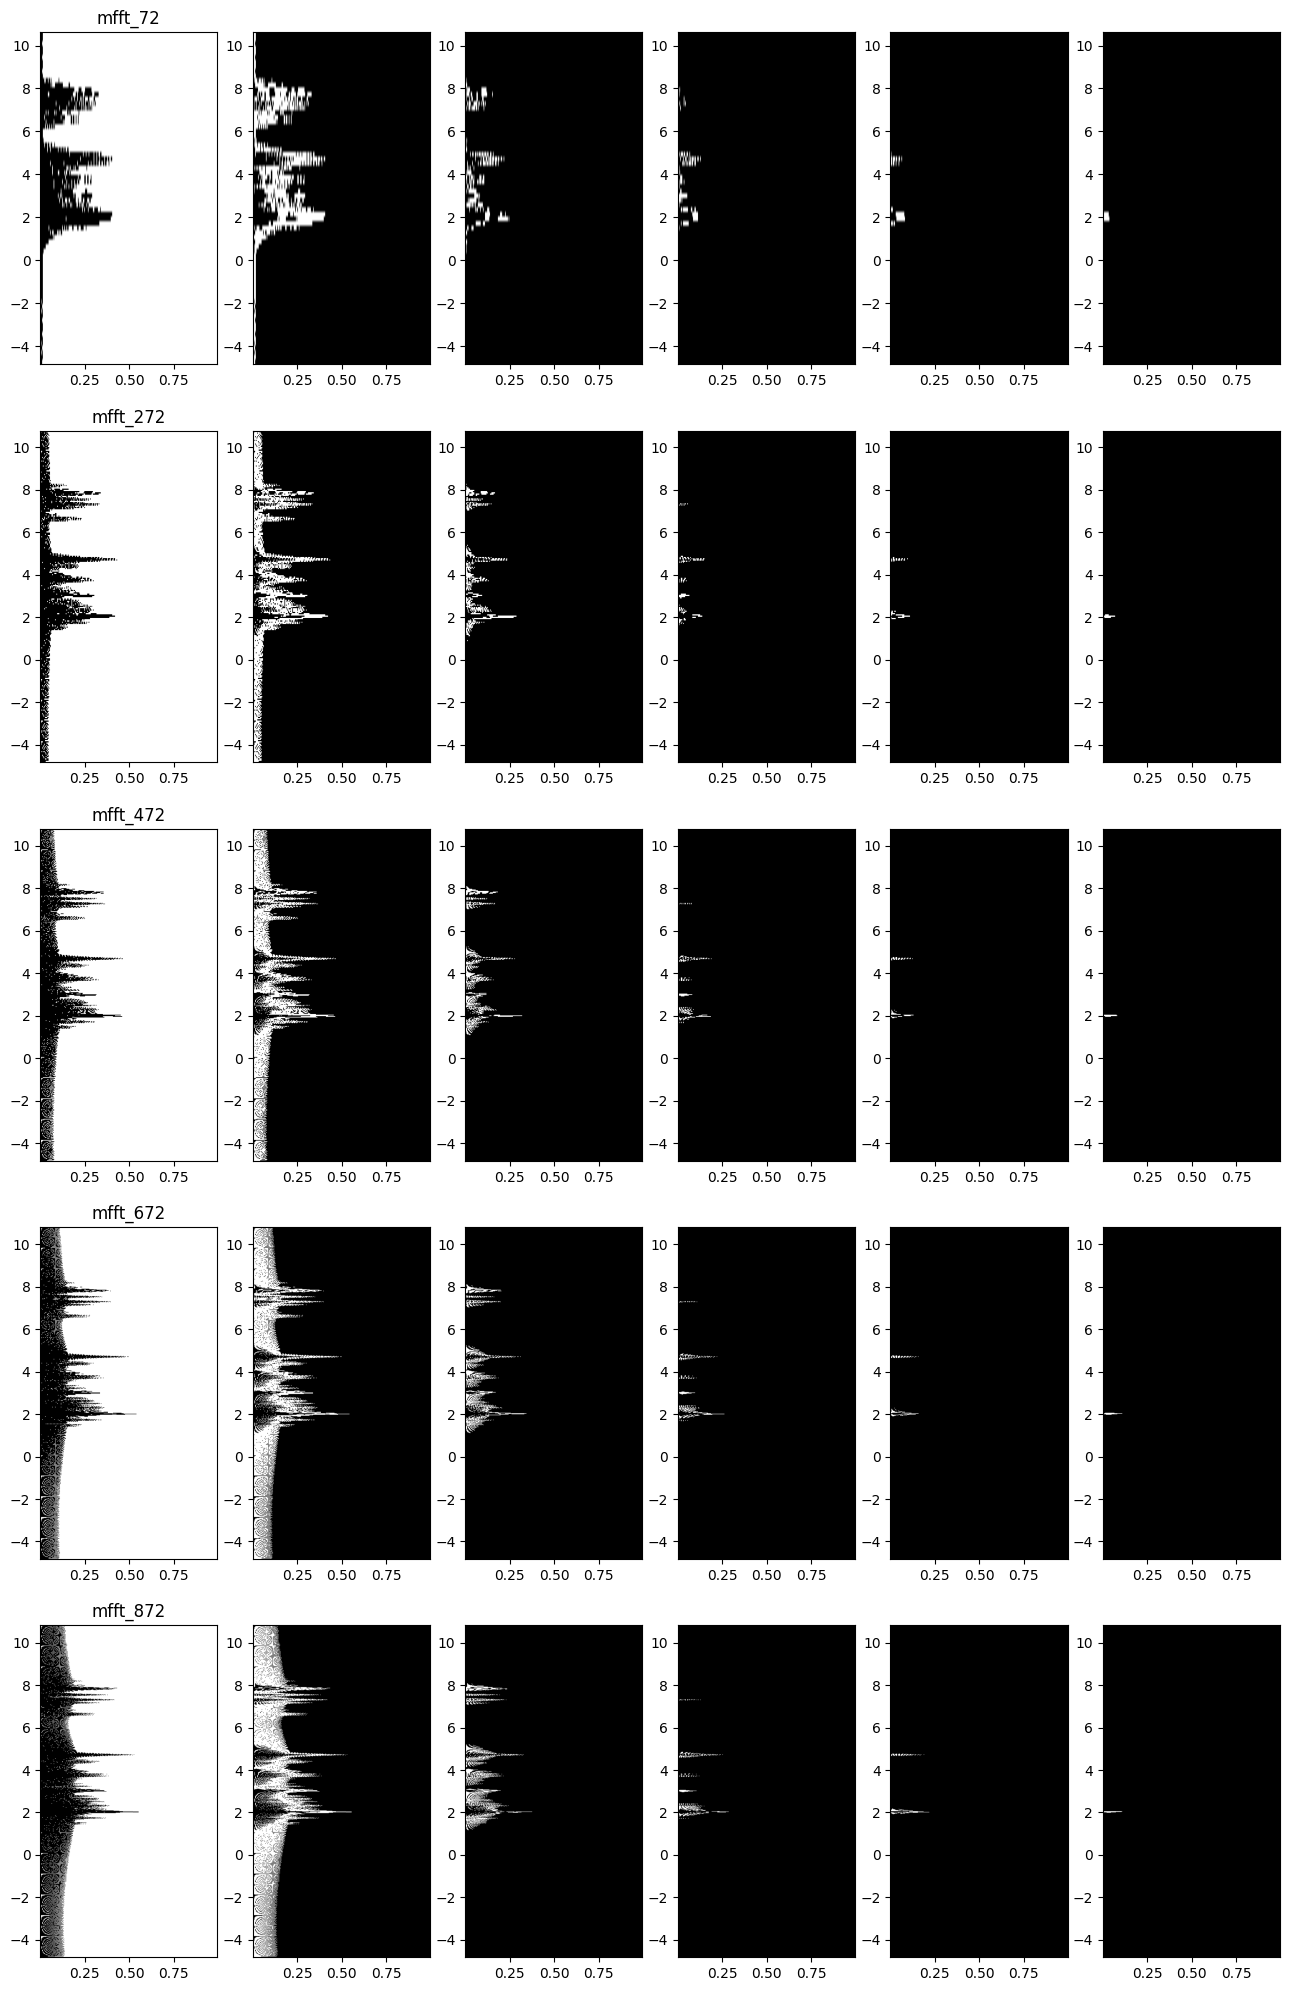

In [25]:
fig,ax = plt.subplots(5,6,figsize=(16,25))
plot_id = np.arange(2,len(mfft_),10)
row = 0
for idx in range(len(plot_id)):
    seg_res = np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][0][0,:,:])) < 0.001
    seg_res2 = (np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][0][0,:,:])) > 0.001).astype('int')*(np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][0][0,:,:])) < 0.02).astype('int')
    seg_res3 = (np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][0][0,:,:])) > 0.02).astype('int')*(np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][0][0,:,:])) < 0.08).astype('int')
    seg_res4 = (np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][0][0,:,:])) > 0.08).astype('int')*(np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][0][0,:,:])) < 0.2).astype('int')
    seg_res5 = (np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][0][0,:,:])) > 0.2).astype('int')*(np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][0][0,:,:])) < 0.6).astype('int')
    seg_res6 = (np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][0][0,:,:])) > 0.6).astype('int')*(np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][0][0,:,:])) < 1).astype('int')
    ax.flat[6*row].imshow(seg_res,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][-1][0],spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][-1][-1],
                    np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][2])[0],np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][2])[-1]))
    ax.flat[6*row+1].imshow(seg_res2,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][-1][0],spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][-1][-1],
                    np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][2])[0],np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][2])[-1]))
    ax.flat[6*row+2].imshow(seg_res3,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][-1][0],spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][-1][-1],
                    np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][2])[0],np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][2])[-1]))
    ax.flat[6*row+3].imshow(seg_res4,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][-1][0],spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][-1][-1],
                    np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][2])[0],np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][2])[-1]))
    ax.flat[6*row+4].imshow(seg_res5,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][-1][0],spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][-1][-1],
                    np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][2])[0],np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][2])[-1]))
    ax.flat[6*row+5].imshow(seg_res6,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][-1][0],spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][-1][-1],
                    np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][2])[0],np.flip(spgram_mfft['mfft_'+str(mfft_[plot_id[idx]])][2])[-1]))
    ax.flat[6*row].set_title('mfft_'+str(mfft_[plot_id[idx]]))
    row = row+1

% of pixels in each segmented region x mfft value:

In [26]:
regions = [0.001,0.02,0.08,0.2,0.6]
hist, bins, bins_centered, qntty_percent_regions = funcstud.histogram_for_different_spgram_and_qntty_per_histogram_region(spgram_dict=spgram_mfft,nbins=5000,part='real',regions=regions,normalized=True)
hist_absolute, bins_absolute, bins_centered_absolute, qntty_absolute_regions = funcstud.histogram_for_different_spgram_and_qntty_per_histogram_region(spgram_dict=spgram_mfft,nbins=5000,part='real',regions=regions,normalized=False)

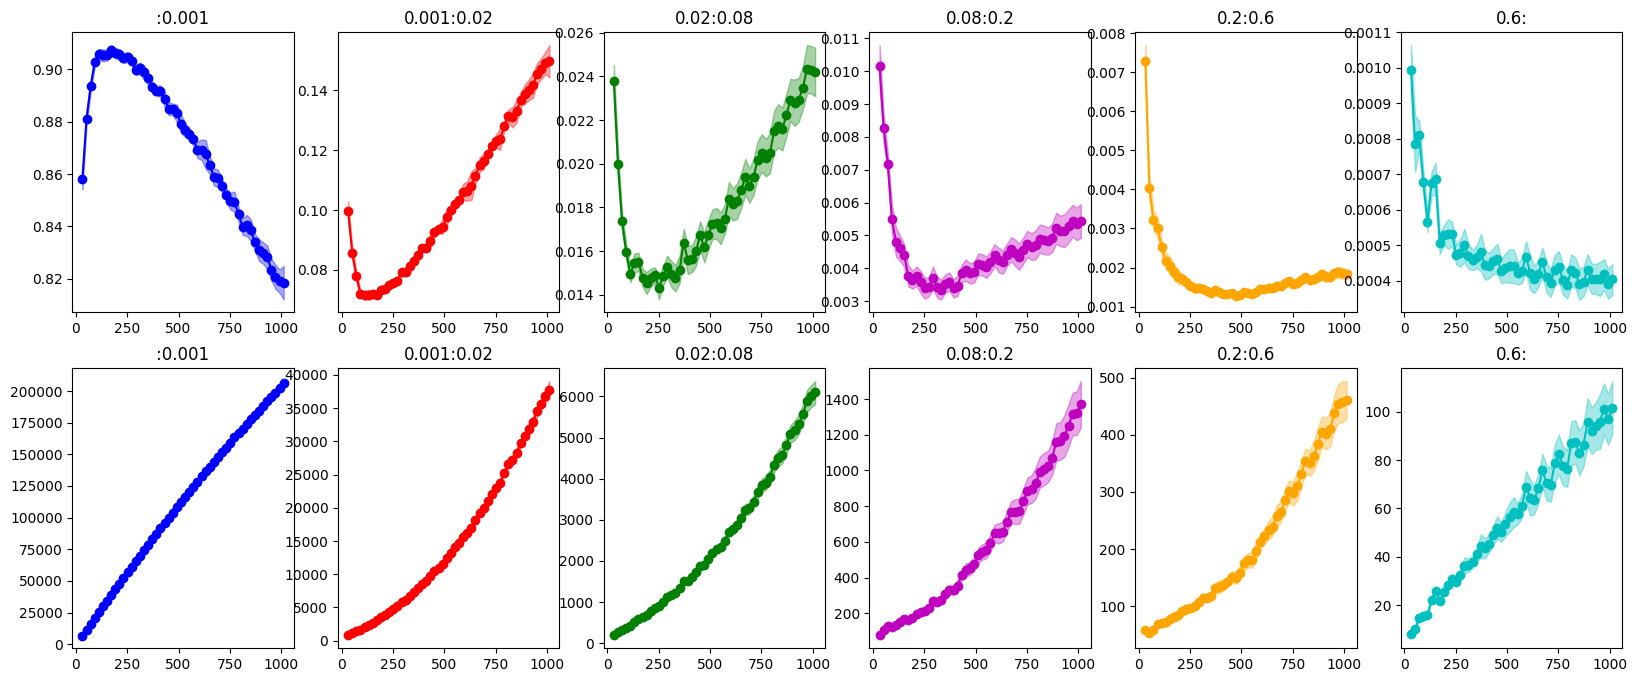

In [27]:
colors = ['b','r','g','m','orange','c']
fig,ax = plt.subplots(2,6,figsize=(20,8))
for i in range(len(list(qntty_percent_regions.keys()))):
    aux = np.array(qntty_percent_regions[list(qntty_percent_regions.keys())[i]]['mean'])
    aux_std = np.array(qntty_percent_regions[list(qntty_percent_regions.keys())[i]]['std'])

    aux_absolute = np.array(qntty_absolute_regions[list(qntty_absolute_regions.keys())[i]]['mean'])
    aux_absolute_std = np.array(qntty_absolute_regions[list(qntty_absolute_regions.keys())[i]]['std'])
    ax[0,i].plot(mfft_,aux,marker='o',color=colors[i])
    ax[0,i].fill_between(mfft_, aux - aux_std, 
                       aux + aux_std, alpha=0.35, color = colors[i])
    ax[0,i].set_title(list(qntty_percent_regions.keys())[i])
    ax[1,i].plot(mfft_,aux_absolute,marker='o',color=colors[i])
    ax[1,i].fill_between(mfft_, aux_absolute - aux_absolute_std, 
                       aux_absolute + aux_absolute_std, alpha=0.35, color = colors[i])
    ax[1,i].set_title(list(qntty_absolute_regions.keys())[i])

Stats of each segmented region x mfft:

In [9]:
stats_per_region = funcstud.stats_per_segmented_regions_for_different_spgrams(regions_threshold=regions,spgram_dict=spgram_mfft, part='real')

In [29]:
stats_global = utils.stats_global_for_different_spgrams(spgram_dict=spgram_mfft, part='part')

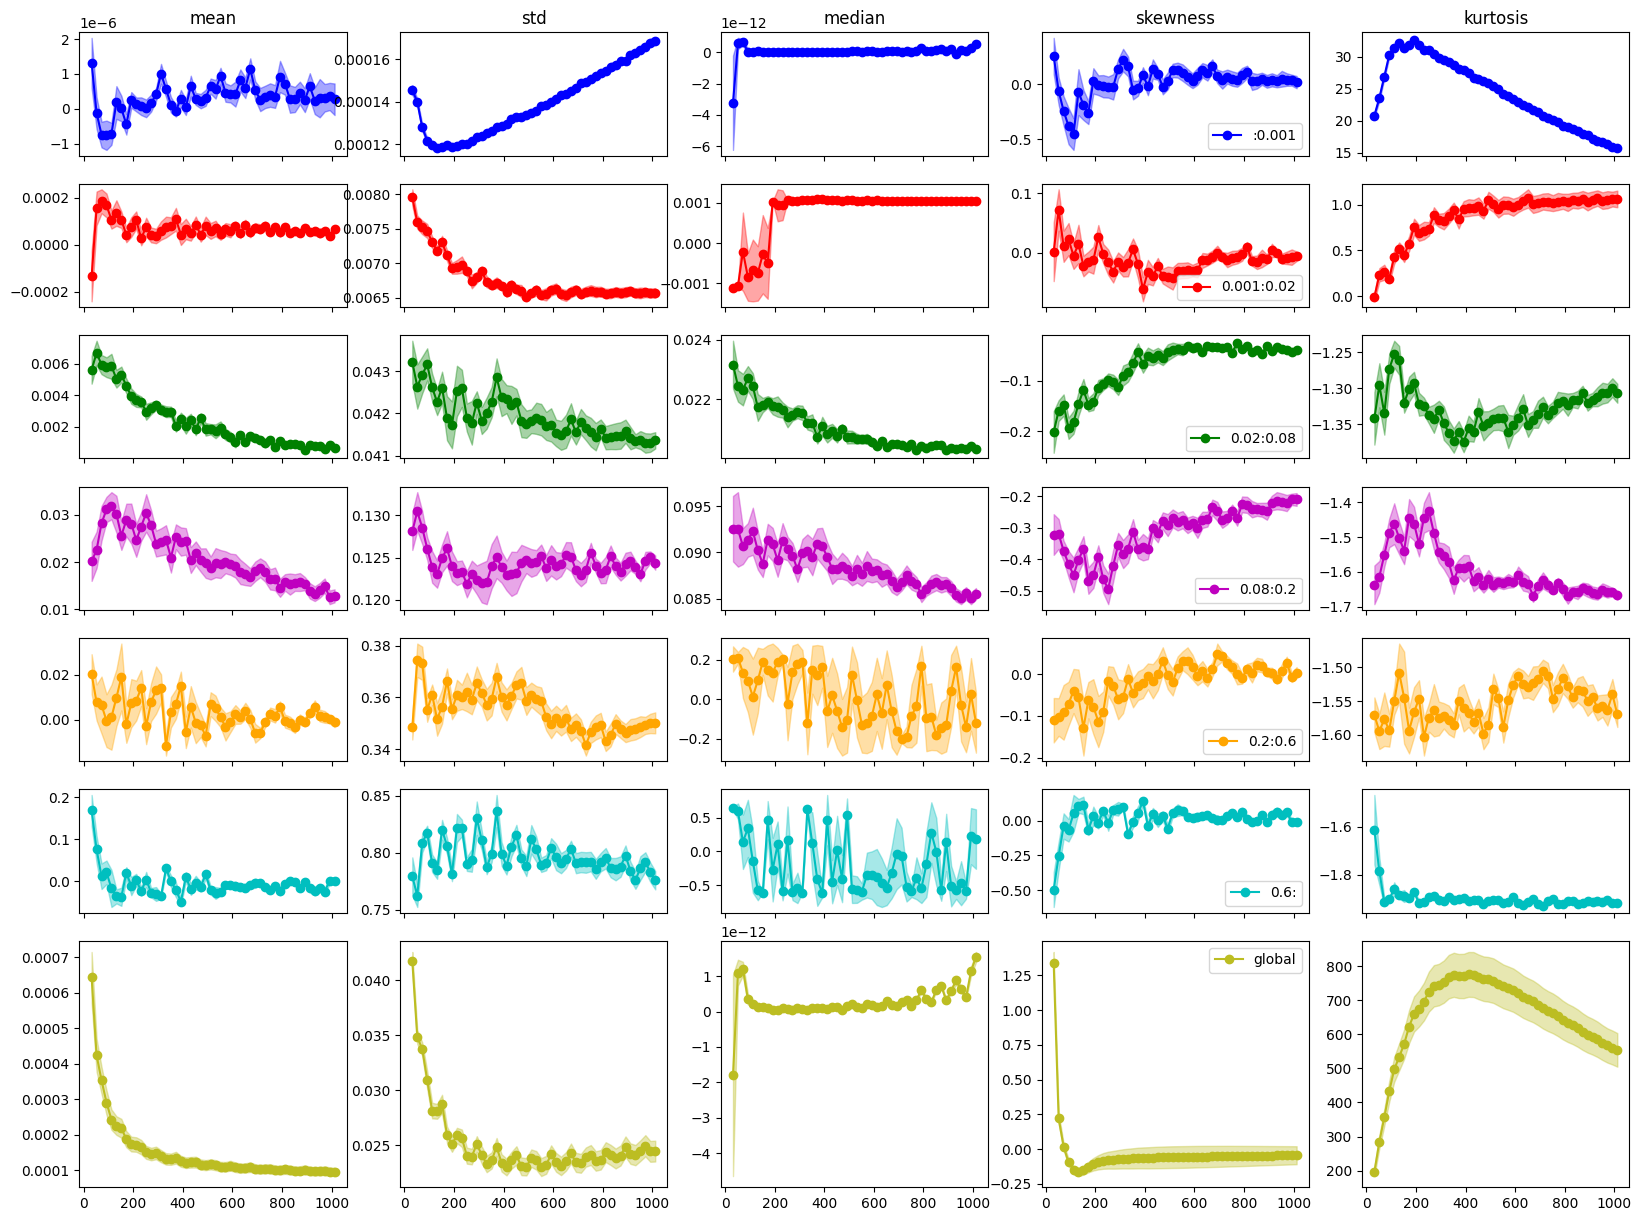

In [11]:
fig,ax = plt.subplots(7,5,figsize=(20,15), sharex='col', height_ratios=[1, 1, 1, 1, 1, 1, 2])

stat_name = ['mean','std','median','skewness','kurtosis']
colors = ['b','r','g','m','orange','c']
for j in range(len(stat_name)):
    for i in range(len(list(stats_per_region[stat_name[j]].keys()))):
        aux = np.array(stats_per_region[stat_name[j]][list(stats_per_region[stat_name[j]].keys())[i]]['mean'])
        aux_std = np.array(stats_per_region[stat_name[j]][list(stats_per_region[stat_name[j]].keys())[i]]['std'])
        ax[i,j].plot(mfft_,aux,marker='o',color=colors[i],label=list(stats_per_region[stat_name[j]].keys())[i])
        ax[i,j].fill_between(mfft_, aux - aux_std, 
                           aux + aux_std, alpha=0.35, color = colors[i])
        if i == 0:
            ax[i,j].set_title(stat_name[j])
        if j == 3:
            ax[i,j].legend(loc='lower right')
colors = ['#bcbd22']
for i in range(len(stat_name)):
    aux = np.array(stats_global[stat_name[i]]['mean'])
    aux_std = np.array(stats_global[stat_name[i]]['std'])
    ax[6,i].plot(mfft_,aux,marker='o',color=colors[0],label="global")
    ax[6,i].fill_between(mfft_, aux - aux_std, 
                       aux + aux_std, alpha=0.35, color = colors[0])
    if i == 3:
        ax[6,i].legend(loc='upper right')
plt.show()

Checking visually the metrics obtained:

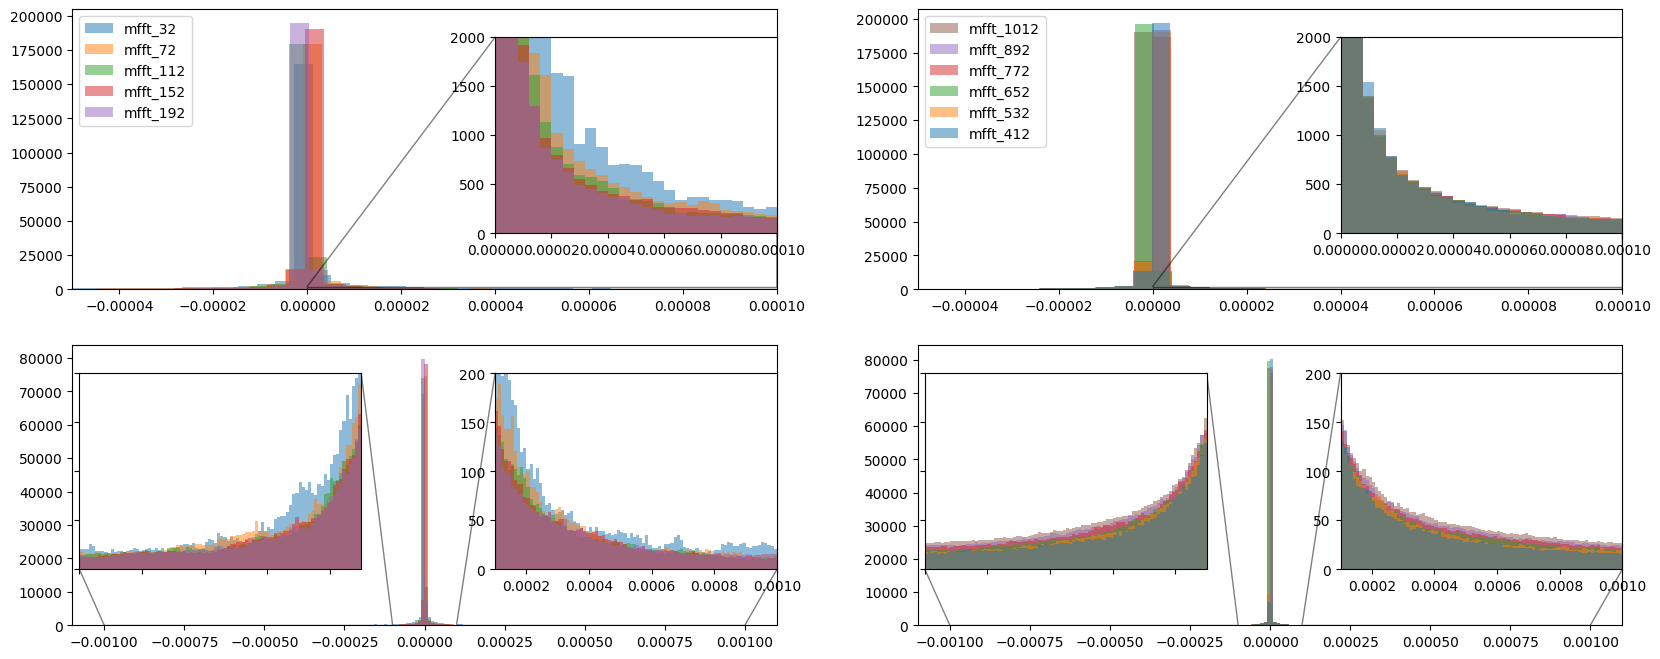

In [12]:
fig,ax = plt.subplots(2,2,figsize=(20,8))
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
plot_id = np.arange(0,9,2)
for i in (range(len(plot_id))):
    seg_ = np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:])) < 0.001
    aux = np.real(seg_*spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:]).ravel()
    ax[0,0].hist(aux,500,alpha=0.5,density = True,label = 'mfft_'+str(mfft_[plot_id[i]]),color=colors[i])
    ax[1,0].hist(aux,200,alpha=0.5,density = True,label = 'mfft_'+str(mfft_[plot_id[i]]),color=colors[i])
    ax[0,0].set_xlim(-0.00005,0.0001)
    ax[0,0].legend(loc='upper left')

axins_0 = ax[0,0].inset_axes([0.6, 0.2, 0.4, 0.7], 
                              xlim=(0.0, 0.0001), ylim=(0, 2000))
ax[0,0].indicate_inset_zoom(axins_0, edgecolor="black")


axins = ax[1,0].inset_axes([0.6, 0.2, 0.4, 0.7], 
                              xlim=(0.0001, 0.001), ylim=(0, 200))
ax[1,0].indicate_inset_zoom(axins, edgecolor="black")
axins2 = ax[1,0].inset_axes([0.01, 0.2, 0.4, 0.7], 
                              xlim=(-0.001, -0.0001), ylim=(0, 200),
                               xticklabels=[], yticklabels=[])
ax[1,0].indicate_inset_zoom(axins2, edgecolor="black")
for i in (range(len(plot_id))):
        seg_ = np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0])) < 0.001
        aux = np.real(seg_*spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0]).ravel()
        axins_0.hist(aux, bins=500, alpha=0.5,density=True,color=colors[i])
        axins.hist(aux, bins=200, alpha=0.5,density=True,color=colors[i])
        axins2.hist(aux, bins=200,alpha=0.5,density=True,color=colors[i])

plot_id = np.arange(19,len(mfft_),6)
for i in reversed(range(len(plot_id))):
    seg_ = np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:])) < 0.001
    aux = np.real(seg_*spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:]).ravel()
    ax[0,1].hist(aux,500,alpha=0.5,density = True,label = 'mfft_'+str(mfft_[plot_id[i]]),color=colors[i])
    ax[1,1].hist(aux,200,alpha=0.5,density = True,label = 'mfft_'+str(mfft_[plot_id[i]]),color=colors[i])
    ax[0,1].set_xlim(-0.00005,0.0001)
    ax[0,1].legend(loc='upper left')

axins_5 = ax[0,1].inset_axes([0.6, 0.2, 0.4, 0.7], 
                              xlim=(0.0, 0.0001), ylim=(0, 2000))
ax[0,1].indicate_inset_zoom(axins_5, edgecolor="black")

axins3 = ax[1,1].inset_axes([0.6, 0.2, 0.4, 0.7], 
                              xlim=(0.0001, 0.001), ylim=(0, 200))
ax[1,1].indicate_inset_zoom(axins3, edgecolor="black")
axins4 = ax[1,1].inset_axes([0.01, 0.2, 0.4, 0.7], 
                              xlim=(-0.001, -0.0001), ylim=(0, 200),
                            xticklabels=[], yticklabels=[])
ax[1,1].indicate_inset_zoom(axins4, edgecolor="black")
for i in reversed(range(len(plot_id))):
        seg_ = np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0])) < 0.001
        aux = np.real(seg_*spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0]).ravel()
        axins_5.hist(aux, bins=500, alpha=0.5,density=True,color=colors[i])
        axins3.hist(aux, bins=200, alpha=0.5,density=True,color=colors[i])
        axins4.hist(aux, bins=200,alpha=0.5,density=True,color=colors[i])

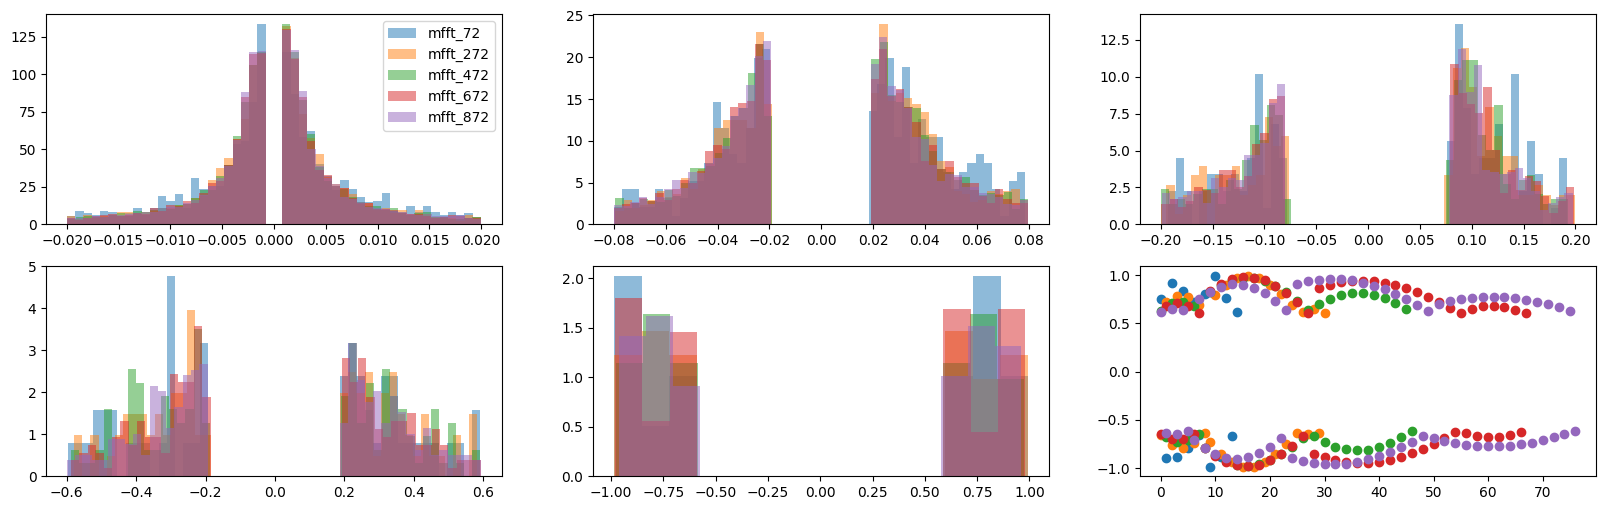

In [32]:
fig,ax = plt.subplots(2,3,figsize=(20,6))
plot_id = np.arange(2,len(mfft_),10)
for i in (range(len(plot_id))):
    seg_2 = (np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:])) > 0.001).astype('int')*(np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:])) < 0.02).astype('int')
    aux = np.real(seg_2*spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    ax.flat[0].hist(aux_no_zeros,50,alpha=0.5,density = True,label = 'mfft_'+str(mfft_[plot_id[i]]))
    seg_3 = (np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:])) > 0.02).astype('int')*(np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:])) < 0.08).astype('int')
    aux = np.real(seg_3*spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    ax.flat[1].hist(aux_no_zeros,50,alpha=0.5,density = True,label = 'mfft_'+str(mfft_[plot_id[i]]))
    seg_4 = (np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:])) > 0.08).astype('int')*(np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:])) < 0.2).astype('int')
    aux = np.real(seg_4*spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    ax.flat[2].hist(aux_no_zeros,50,alpha=0.5,density = True,label = 'mfft_'+str(mfft_[plot_id[i]]))
    seg_5 = (np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:])) > 0.2).astype('int')*(np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:])) < 0.6).astype('int')
    aux = np.real(seg_5*spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    ax.flat[3].hist(aux_no_zeros,50,alpha=0.5,density = True,label = 'mfft_'+str(mfft_[plot_id[i]]))
    seg_6 = (np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:])) > 0.6).astype('int')
    aux = np.real(seg_6*spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    ax.flat[4].hist(aux_no_zeros,15,alpha=0.5,density = True,label = 'mfft_'+str(mfft_[plot_id[i]]))
    ax.flat[5].scatter(np.arange(aux_no_zeros.shape[0]),aux_no_zeros,marker='o')

ax.flat[0].legend(loc='upper right')

In [13]:
from scipy import stats
for reg in list(stats_per_region['std'].keys()):
    print("test hypothesis (kurt/std) residual for region ",reg,":",stats.pearsonr(stats_per_region['std'][reg]['mean'], stats_per_region['kurtosis'][reg]['mean']))

test hypothesis (kurt/std) residual for region  :0.001 : PearsonRResult(statistic=-0.9935766643322902, pvalue=4.3570153867822155e-47)
test hypothesis (kurt/std) residual for region  0.001:0.02 : PearsonRResult(statistic=-0.9909443546760427, pvalue=1.6081764105499676e-43)
test hypothesis (kurt/std) residual for region  0.02:0.08 : PearsonRResult(statistic=-0.008761464392494374, pvalue=0.9518473649897284)
test hypothesis (kurt/std) residual for region  0.08:0.2 : PearsonRResult(statistic=-0.13448968216452334, pvalue=0.3517644306653206)
test hypothesis (kurt/std) residual for region  0.2:0.6 : PearsonRResult(statistic=-0.6427396449844125, pvalue=4.838524593303622e-07)
test hypothesis (kurt/std) residual for region  0.6: : PearsonRResult(statistic=-0.24920167876799953, pvalue=0.08094960981640414)


In [14]:
from scipy import stats
for reg in list(stats_per_region['std'].keys()):
    print("test hypothesis (skew/mean) residual for region ",reg,":",stats.pearsonr(stats_per_region['mean'][reg]['mean'], stats_per_region['skewness'][reg]['mean']))

test hypothesis (skew/mean) residual for region  :0.001 : PearsonRResult(statistic=0.9088639462897523, pvalue=7.411603781587224e-20)
test hypothesis (skew/mean) residual for region  0.001:0.02 : PearsonRResult(statistic=0.3583260241898737, pvalue=0.010614834216261648)
test hypothesis (skew/mean) residual for region  0.02:0.08 : PearsonRResult(statistic=-0.9486824552375464, pvalue=1.205433928588219e-25)
test hypothesis (skew/mean) residual for region  0.08:0.2 : PearsonRResult(statistic=-0.9644632896638229, pvalue=2.1292651796349338e-29)
test hypothesis (skew/mean) residual for region  0.2:0.6 : PearsonRResult(statistic=-0.6970552643498115, pvalue=1.872620954411198e-08)
test hypothesis (skew/mean) residual for region  0.6: : PearsonRResult(statistic=-0.9989498629540442, pvalue=6.146739892484693e-66)


In [35]:
plot_id = np.arange(2,len(mfft_),10)
for i in (range(len(plot_id))):
    seg_3 = (np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:])) > 0.2).astype('int')*(np.abs(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:])) < 0.6).astype('int')
    aux = np.real(seg_3*spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    hist_aux,bins_aux = np.histogram(aux_no_zeros,50,density = True)
    idx = []
    for k in range(len(hist_aux)):
        if hist_aux[k] == 0:
            idx.append(k)
    print(np.sum(hist_aux[:idx[0]]),np.sum(hist_aux[idx[-1]+1:]))

7.148927886996052 1.5886506415546666
0.9902500435412069 1.4853750653118105
3.5058230634256518 0.6374223751683066
21.639293049394336 20.6984542211598
20.842999349352446 21.097182268246982


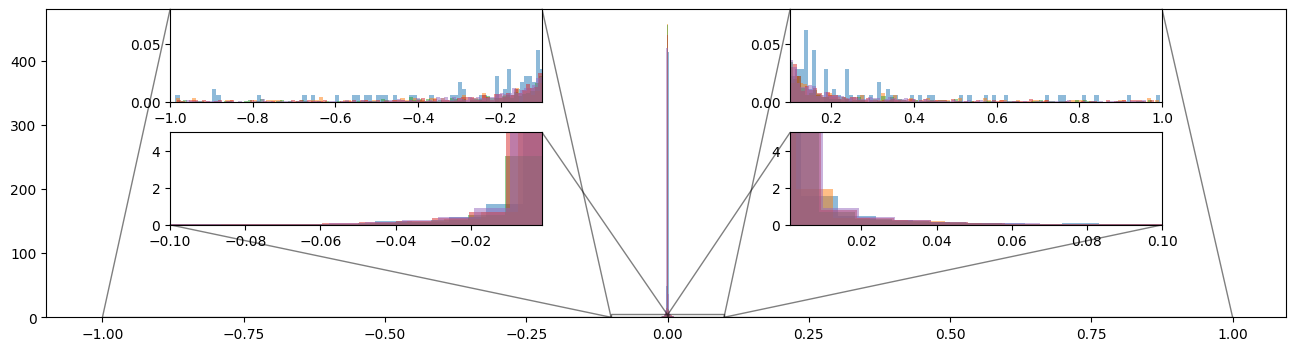

In [36]:
plot_id = np.arange(2,len(mfft_),10)
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

fig,ax = plt.subplots(1,1,figsize=(16,4))
for i in (range(len(plot_id))):
    plt.hist(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:]).ravel(),1000,alpha=0.5,density = True,label = 'mfft_'+str(mfft_[plot_id[i]]))



axins = ax.inset_axes([0.1, 0.7, 0.3, 0.3], xlim=(-1, -0.1), ylim=(0, 0.08))
ax.indicate_inset_zoom(axins, edgecolor="black")

# Create the second inset (-0.1, -0.001)
axins2 = ax.inset_axes([0.1, 0.3, 0.3, 0.3], xlim=(-0.1, -0.001), ylim=(0, 5))
ax.indicate_inset_zoom(axins2, edgecolor="black")

# Create the third inset (0.001, 0.1)
axins3 = ax.inset_axes([0.6, 0.3, 0.3, 0.3], xlim=(0.001, 0.1), ylim=(0, 5))
ax.indicate_inset_zoom(axins3, edgecolor="black")

# Create the fourth inset (0.1, 1)
axins4 = ax.inset_axes([0.6, 0.7, 0.3, 0.3], xlim=(0.1, 1), ylim=(0, 0.08))
ax.indicate_inset_zoom(axins4, edgecolor="black")


for i in (range(len(plot_id))):
        axins.hist(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:]).ravel(), bins=200, alpha=0.5,density=True,color=colors[i])
        axins2.hist(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:]).ravel(), bins=200,alpha=0.5,density=True,color=colors[i])
        axins3.hist(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:]).ravel(), bins=200, alpha=0.5,density=True,color=colors[i])
        axins4.hist(np.real(spgram_mfft['mfft_'+str(mfft_[plot_id[i]])][0][0,:,:]).ravel(), bins=200, alpha=0.5,density=True,color=colors[i])

In [15]:
print('mean')
for reg in list(stats_per_region['mean'].keys()):
    print("test hypothesis (mean) global and ",reg,":",stats.pearsonr(stats_per_region['mean'][reg]['mean'], stats_global['mean']['mean']))
print('std')
for reg in list(stats_per_region['std'].keys()):
    print("test hypothesis (std) global and ",reg,":",stats.pearsonr(stats_per_region['std'][reg]['mean'], stats_global['std']['mean']))

mean
test hypothesis (mean) global and  :0.001 : PearsonRResult(statistic=-0.17782815806153845, pvalue=0.21664208959374204)
test hypothesis (mean) global and  0.001:0.02 : PearsonRResult(statistic=-0.09239174614577882, pvalue=0.5233750953021788)
test hypothesis (mean) global and  0.02:0.08 : PearsonRResult(statistic=0.7970464866482069, pvalue=4.361728041664713e-12)
test hypothesis (mean) global and  0.08:0.2 : PearsonRResult(statistic=0.4269021386143767, pvalue=0.0019898408529479047)
test hypothesis (mean) global and  0.2:0.6 : PearsonRResult(statistic=0.480126512858963, pvalue=0.000417868061514976)
test hypothesis (mean) global and  0.6: : PearsonRResult(statistic=0.7742213385213312, pvalue=4.257348111506898e-11)
std
test hypothesis (std) global and  :0.001 : PearsonRResult(statistic=-0.16052542245235688, pvalue=0.2654434703923186)
test hypothesis (std) global and  0.001:0.02 : PearsonRResult(statistic=0.9246758762551099, pvalue=9.175034420122576e-22)
test hypothesis (std) global and 

In [38]:
stats.pearsonr(stats_global['std']['mean'], stats_global['kurtosis']['mean'])

PearsonRResult(statistic=-0.8743482117013388, pvalue=1.1045628315561053e-16)

In [39]:
stats.pearsonr(stats_global['mean']['mean'], stats_global['skewness']['mean'])

PearsonRResult(statistic=0.7585824369682115, pvalue=1.7507193112576868e-10)

In [40]:
if test_not_save == False:
    zcr_list = {}
    zcr_list['NAA'] = {}
    zcr_list['NAA']['mean'] = list(zcr_['NAA']['mean'])
    zcr_list['NAA']['std'] = list(zcr_['NAA']['std'])
    zcr_list['GABA'] = {}
    zcr_list['GABA']['mean'] = list(zcr_['GABA']['mean'])
    zcr_list['GABA']['std'] = list(zcr_['GABA']['std'])
    zcr_list['Glx'] = {}
    zcr_list['Glx']['mean'] = list(zcr_['Glx']['mean'])
    zcr_list['Glx']['std'] = list(zcr_['Glx']['std'])
    with open("quantitative_metrics_no_noise_mfft_variation_hop_8.txt", "w") as f:
        f.write("fwhm_mfft=")
        f.write(json.dumps(fwhm_mfft))
        f.write('\n')
        f.write("fwhm_mfft_real=")
        f.write(json.dumps(fwhm_mfft_real))
        f.write('\n')
        f.write("sum_segment=")
        f.write(json.dumps(sum_segment))
        f.write('\n')
        f.write("zcr_=")
        f.write(json.dumps(zcr_list))
        f.write('\n')
        f.write("max_sec=")
        f.write(json.dumps(max_sec))
        f.write('\n')
        f.write("qntty_percent_regions=")
        f.write(json.dumps(qntty_percent_regions))
        f.write('\n')
        f.write("qntty_absolute_regions=")
        f.write(json.dumps(qntty_absolute_regions))
        f.write('\n')
        f.write("stats_per_region=")
        f.write(json.dumps(stats_per_region))
        f.write('\n')
        f.write("stats_global=")
        f.write(json.dumps(stats_global))